# Overview

    In NCAA Division 1 college soccer, understanding the factors that contribute to success can be the difference between winning and losing a game. This is especially true in the Men's Big West Conference, where the margins between teams are often razor-thin. The question of which metrics have the most significant influence on winning a game in this conference is vital for coaches and teams looking to gain a competitive edge. By identifying the key performance indicators that consistently correlate with wins, teams can tailor their practice sessions, optimize player performance, and make informed decisions both on and off the field. 
    
    This analysis leverages historical match data from Wyscout, a leading soccer data platform, to apply machine learning techniques and statistical analysis in uncovering the metrics that have the most substantial impact on game outcomes. Understanding these factors is crucial for developing winning strategies and achieving success in one of the most competitive collegiate soccer environments.

[Results Summary](#results_summary)

In [4]:
# Libraries for data work, model building, evaluation, and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from collections import defaultdict
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

We complete out first step for organizing and accessing soccer performance data by dynamically reading CSV files for each school and file type into a structured dictionary. This setup streamlines data management, ensuring that you can efficiently analyze different aspects of each team's performance and identify key metrics influencing success in the Men's Big West Conference.

In [6]:
# Reading CSV files for each school and file type, then storing them in a dictionary 
schools = {'UCSD', 'UCSB', 'UCI', 'UCD', 'UCR', 'CSUF', 'CSUB', 'CSUN', 'CalPoly', 'SacState'}
file_types = {'general', 'defense', 'offense'}
df = {}

for school in schools:
    for file_type in file_types:
        file_name = f'{school.lower()}_{file_type}.csv'
        df[f'{school}_{file_type}'] = pd.read_csv(file_name)


The transformation of current performance data into meaningful ratios highlights key aspects of each team's play. By calculating and adding these ratios, we create a more nuanced dataset that allows for in-depth analysis of how specific performance metrics contribute to winning games. This step is crucial for identifying if ratios have the strongest correlation with success, enabling more targeted strategies and insights.

In [8]:
# Create new feature ratios and add them as new columns to the DataFrame
def calculate_ratios(df, calculations):
    for new_col, numerator, denominator in calculations:
        if numerator in df.columns and denominator in df.columns:
            df[new_col] = (df[numerator] / df[denominator]).round(3)
        else:
            print(f"Missing columns for {new_col}: {numerator}, {denominator} in DataFrame columns {df.columns}")

# Ratios of data from the 'general' file
general_calculations = [
    ('Shots on target ratio', 'Shots on target', 'Shots'),
    ('Shots inside penalty area ratio', 'Shots inside penalty area', 'Shots'),
    ('Shots on target inside penalty area ratio', 'Shots on target inside penalty area', 'Shots'),
    ('Shots outside penalty area ratio', 'Shots outside penalty area', 'Shots'),
    ('Shots on target outside penalty area ratio', 'Shots on target outside penalty area', 'Shots')
]

# Ratios of data from the 'defense' file
defensive_calculations = [
    ('Low recoveries ratio', 'Low Recovery', 'Recoveries'),
    ('Med recoveries ratio', 'Medium Recovery', 'Recoveries'),
    ('High recoveries ratio', 'High Recovery', 'Recoveries'),
    ('Low loss ratio', 'Low loss', 'Losses (dispossesion)'),
    ('Med loss ratio', 'Medium loss', 'Losses (dispossesion)'),
    ('High loss ratio', 'High loss', 'Losses (dispossesion)'),
    ('Duels won ratio', 'Total duels won', 'Total duels'),
    ('Offensive duels won ratio', 'Offensive duels won', 'Offensive duels'),
    ('Defensive duels won ratio', 'Defensive duels won', 'Defensive duels'),
    ('Loose ball duels won ratio', 'Loose ball duels won', 'Loose ball duels'),
    ('Aerial duels won ratio', 'Aerial duels won', 'Aerial duels'),
    ('Successful dribbles ratio', 'Successful dribbles', 'Dribbles')
]

# Ratios of data from the 'offense' file
offensive_calculations = [
    ('Total attacks ending with shots ratio', 'Total attacks ending with shots', 'Total attacks'),
    ('Positional attacks ending with shots ratio', 'Positional attacks ending with shots', 'Positional attacks'),
    ('Total pass accuracy ratio', 'Total accurate passes', 'Total passes'),
    ('Forward pass accuracy ratio', 'Accurate forward passes', 'Forward passes'),
    ('Back pass accuracy ratio', 'Accurate back passes', 'Back passes'),
    ('Lateral pass accuracy ratio', 'Accurate lateral passes', 'Lateral passes'),
    ('Progressive pass accuracy ratio', 'Accurate progressive passes', 'Progressive passes'),
    ('Long pass accuracy ratio', 'Accurate long passes', 'Long passes'),
    ('Accurate pass to final third ratio', 'Accurate passes to final third', 'Passes to final third'),
    ('Accurate pass to penalty area ratio', 'Accurate passes to penalty area', 'Passes to penalty area'),
    ('Through pass accuracy ratio', 'Accurate through passes', 'Through passes'),
    ('Accurate cross ratio', 'Accurate crosses', 'Crosses'),
    ('Low cross ratio', 'Low crosses', 'Crosses'),
    ('High cross ratio', 'High crosses', 'Crosses')
]

# Apply the ratio calculations to each df based on the file type
for school in schools:
    for file_type in file_types:
        df_name = f'{school}_{file_type}'
        if df_name in df:
            if file_type == 'general':
                calculate_ratios(df[df_name], general_calculations)
            elif file_type == 'defense':
                calculate_ratios(df[df_name], defensive_calculations)
            elif file_type == 'offense':
                calculate_ratios(df[df_name], offensive_calculations)

Standardizing time-related data across different datasets plays a crucial role in ensuring consistency, as it involves converting 'MM:SS' formats into total seconds. By merging the general, offense, and defense dataframes and transforming these time metrics, we create a unified dataset for each school that becomes easier to analyze. This uniformity in time measurement is essential for accurately evaluating performance metrics and identifying the factors that contribute to success in soccer matches.

In [13]:
# Convert a time string in 'MM:SS' format to total seconds
def time_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

# Merge the general, offense, and defense df on the 'School' column, apply time_to_seconds, and then remove the original time columns
def process_df(general_df, offense_df, defense_df):
    merged_df = pd.merge(general_df, offense_df, on='School')
    merged_df = pd.merge(merged_df, defense_df, on='School')
   
    merged_df['Pure possession time (seconds)'] = merged_df['Pure possession time'].apply(time_to_seconds)
    merged_df['Average possession duration (seconds)'] = merged_df['Average possession duration'].apply(time_to_seconds)
    merged_df = merged_df.drop(columns=['Pure possession time', 'Average possession duration'])
    
    return merged_df

# Apply the process_df function to each school's data
merged_ucsd_df = process_df(df['UCSD_general'], df['UCSD_offense'], df['UCSD_defense'])
merged_csuf_df = process_df(df['CSUF_general'], df['CSUF_offense'], df['CSUF_defense'])
merged_uci_df = process_df(df['UCI_general'], df['UCI_offense'], df['UCI_defense'])
merged_ucd_df = process_df(df['UCD_general'], df['UCD_offense'], df['UCD_defense'])
merged_ucr_df = process_df(df['UCR_general'], df['UCR_offense'], df['UCR_defense'])
merged_ucsb_df = process_df(df['UCSB_general'], df['UCSB_offense'], df['UCSB_defense'])
merged_sacstate_df = process_df(df['SacState_general'], df['SacState_offense'], df['SacState_defense'])
merged_calpoly_df = process_df(df['CalPoly_general'], df['CalPoly_offense'], df['CalPoly_defense'])
merged_csun_df = process_df(df['CSUN_general'], df['CSUN_offense'], df['CSUN_defense'])
merged_csub_df = process_df(df['CSUB_general'], df['CSUB_offense'], df['CSUB_defense'])

# Sample of what the merged df looks like 
merged_ucsd_df

,School,Points,Goals,xG,Shots,Shots on target,Shots on post,Shots blocked,Shots wide,Shots inside penalty area,...,Med loss ratio,High loss ratio,Duels won ratio,Offensive duels won ratio,Defensive duels won ratio,Loose ball duels won ratio,Aerial duels won ratio,Successful dribbles ratio,Pure possession time (seconds),Average possession duration (seconds)
0,UCI,0,1,0.93,15,6,0,2,7,5,...,0.428,0.409,0.516,0.494,0.536,0.533,0.500,0.676,1436,11
1,UCD,0,1,0.97,11,4,0,2,5,8,...,0.314,0.554,0.502,0.432,0.754,0.444,0.362,0.514,1502,11
2,UCR,3,5,2.01,14,8,0,3,3,7,...,0.289,0.544,0.420,0.337,0.514,0.407,0.455,0.296,1166,10
3,UCSB,3,3,1.10,8,6,0,1,1,5,...,0.348,0.464,0.449,0.333,0.661,0.372,0.446,0.516,1150,10
4,Sac State,1,0,2.59,12,6,0,5,1,9,...,0.244,0.544,0.492,0.604,0.455,0.424,0.444,0.682,1358,12
5,CSUN,0,1,1.44,7,2,1,2,2,4,...,0.325,0.508,0.458,0.338,0.595,0.444,0.438,0.440,1444,13
6,Cal Poly,0,1,0.21,7,2,0,2,3,3,...,0.435,0.408,0.468,0.481,0.507,0.371,0.460,0.636,1488,11
7,CSUF,0,1,1.18,12,3,0,4,5,8,...,0.364,0.542,0.436,0.320,0.606,0.382,0.303,0.500,1186,9
8,CSUB,3,1,1.65,12,3,0,4,5,6,...,0.406,0.475,0.437,0.380,0.533,0.343,0.487,0.481,1348,12


By merging all team-specific dataframes into one comprehensive combined_df, we allow for a holistic analysis of all teams' performance metrics in one place. This aggregation is critical for comparing and identifying key performance indicators across the entire conference, facilitating a more effective analysis of factors influencing success in the Men's Big West Conference.

In [16]:
# Create a dict of all our merged df and concatenate them into a single combined_df
dataframes = {
    'UCSD': merged_ucsd_df,
    'CSUF': merged_csuf_df,
    'UCI': merged_uci_df,
    'UCD': merged_ucd_df,
    'UCR': merged_ucr_df,
    'UCSB': merged_ucsb_df,
    'Sac State': merged_sacstate_df,
    'Cal Poly': merged_calpoly_df,
    'CSUN': merged_csun_df,
    'CSUB': merged_csub_df,
}

combined_df = pd.concat(dataframes.values(), ignore_index=True)
combined_df

,School,Points,Goals,xG,Shots,Shots on target,Shots on post,Shots blocked,Shots wide,Shots inside penalty area,...,Med loss ratio,High loss ratio,Duels won ratio,Offensive duels won ratio,Defensive duels won ratio,Loose ball duels won ratio,Aerial duels won ratio,Successful dribbles ratio,Pure possession time (seconds),Average possession duration (seconds)
0,UCI,0,1,0.93,15,6,0,2,7,5,...,0.428,0.409,0.516,0.494,0.536,0.533,0.500,0.676,1436,11
1,UCD,0,1,0.97,11,4,0,2,5,8,...,0.314,0.554,0.502,0.432,0.754,0.444,0.362,0.514,1502,11
2,UCR,3,5,2.01,14,8,0,3,3,7,...,0.289,0.544,0.420,0.337,0.514,0.407,0.455,0.296,1166,10
3,UCSB,3,3,1.10,8,6,0,1,1,5,...,0.348,0.464,0.449,0.333,0.661,0.372,0.446,0.516,1150,10
4,Sac State,1,0,2.59,12,6,0,5,1,9,...,0.244,0.544,0.492,0.604,0.455,0.424,0.444,0.682,1358,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,Sac State,1,1,2.05,14,6,1,3,4,8,...,0.258,0.573,0.488,0.410,0.741,0.350,0.417,0.630,1497,11
86,UCI,3,2,1.77,10,2,0,2,6,5,...,0.253,0.579,0.439,0.322,0.609,0.368,0.444,0.308,1318,12
87,Cal Poly,1,1,1.07,6,1,0,3,2,3,...,0.350,0.514,0.515,0.359,0.784,0.419,0.479,0.406,1343,10
88,CSUF,0,1,1.28,10,6,0,1,3,5,...,0.354,0.538,0.525,0.421,0.667,0.211,0.587,0.667,1357,11


Identifying metrics where the top three teams—CSUF, UCI, and UCSB—consistently excel is crucial for understanding success in the Men's Big West Conference. By calculating and ranking feature values for these teams, the analysis highlights specific performance indicators that consistently place them among the top three across all features. This approach is significant because it helps pinpoint the metrics that could be essential for other teams looking to improve their performance and achieve similar success.

In [12]:
# List of top 3 teams
top_teams = ['CSUF', 'UCI', 'UCSB']

# Store the ranks for each feature
ranked_features = {}


for feature in dataframes['CSUF'].columns:
    if feature not in ['School', 'Points', 'Team']:  # Exclude non-numeric features or identifiers
        # Store the values for each team for the current feature
        feature_values = {}
        
        # Collect feature values for all teams
        for school, df in dataframes.items():
            feature_values[school] = df[feature].mean()  
        
        # Convert the dictionary to a df and rank the teams based on the feature values
        feature_df = pd.DataFrame.from_dict(feature_values, orient='index', columns=[feature])
        feature_df['Rank'] = feature_df[feature].rank(ascending=False) 
        
        # Filter to include only the top 3 teams
        top_team_ranks = feature_df.loc[top_teams]
        
        # Check if all top teams are in the top 3 for this feature
        if all(top_team_ranks['Rank'] <= 3):
            ranked_features[feature] = top_team_ranks['Rank']

# Output the features where the top 3 teams all ranked in the top 3 for that feature
for feature, ranks in ranked_features.items():
    print(f"Feature: {feature}")
    for team in top_teams:
        print(f"{team}: {int(ranks[team])}")
    print("\n")

Feature: Positional attacks ending with shots
CSUF: 1
UCI: 2
UCSB: 3


Feature: Forward passes
CSUF: 3
UCI: 2
UCSB: 1


Feature: Accurate passes to penalty area
CSUF: 3
UCI: 1
UCSB: 2


Feature: Match tempo
CSUF: 3
UCI: 2
UCSB: 1




Identifying which performance metrics have the greatest impact on match outcomes is crucial for understanding success. By creating a target variable to denote wins, normalizing the data, and using a RandomForest model, the analysis determines the most influential features that affect whether a team wins.

In [14]:
# Create a target variable indicating whether the team won (3 points) or not (0 or 1 point)
combined_df['Win'] = (combined_df['Points'] == 3).astype(int)

# Select numeric columns only
numeric_columns = combined_df.select_dtypes(include=['number']).columns

# Normalize the numeric data (except for the target variable 'Win')
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(combined_df[numeric_columns]), columns=numeric_columns)

# Prepare the data for model training
X = scaled_features.drop(columns=['Points', 'Win'])
y = combined_df['Win']

# Train a RandomForest model to determine feature importance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Select the top 20 features
top_20_features = feature_importances.head(20)

# Output the top 20 features
print("Top 20 Features by Importance:")
print(top_20_features)

Top 20 Features by Importance:
                                   Feature  Importance
0                                    Goals    0.092416
88                              Clearances    0.034307
87                           Interceptions    0.031706
91                            Low Recovery    0.028642
110                               Dribbles    0.027494
72   Total attacks ending with shots ratio    0.024777
1                                       xG    0.022349
19                   Shots on target ratio    0.020822
35      Possessions reaching opponent half    0.018098
79                Long pass accuracy ratio    0.016854
112                   Low recoveries ratio    0.016466
3                          Shots on target    0.016259
124         Pure possession time (seconds)    0.015866
33                   Possession percentage    0.015660
84                         Low cross ratio    0.015148
118                        Duels won ratio    0.015045
90                              Re

Refining the dataset by removing redundant features is essential for improving model efficiency. By calculating correlations and comparing feature importance, the process ensures that only the most relevant metrics are retained for analysis. This step is vital for enhancing both the model's performance and interpretability, focusing on the features that have the greatest impact on match outcomes while avoiding multicollinearity.

In [16]:
# Drop the 'School' and 'Points' column since they are not features of interest
combined_df_dropped = combined_df.drop(columns=['School', 'Points'])

# Ensure all columns are numeric to calculate correlation
combined_df_dropped = combined_df_dropped.apply(pd.to_numeric, errors='coerce')
combined_df_dropped = combined_df_dropped.fillna(combined_df_dropped.mean())

# Compute the correlation matrix
correlation_matrix = combined_df_dropped.corr()

# Identify highly correlated pairs that meet the threshold
threshold = 0.8
high_corr_pairs = [(feature1, feature2) for feature1 in correlation_matrix.columns 
                   for feature2 in correlation_matrix.columns 
                   if feature1 != feature2 and abs(correlation_matrix.loc[feature1, feature2]) > threshold]

# Convert the feature_importances df to a dictionary for quick lookup
feature_importances_dict = feature_importances.set_index('Feature')['Importance'].to_dict()

# Store feature decisions
features_decision = {}

# Remove one feature from each pair based on which feature has the lower importance
features_to_drop = set()
for feature1, feature2 in high_corr_pairs:
    if feature1 not in features_to_drop and feature2 not in features_to_drop:
        if feature1 in features_decision:
            continue
        if feature2 in features_decision:
            continue
        
        # Drops the feature with the lower importance
        if feature_importances_dict.get(feature1, 0) >= feature_importances_dict.get(feature2, 0):
            features_to_drop.add(feature2)
            features_decision[feature1] = 'Kept'
            features_decision[feature2] = 'Dropped'
            print(f"From pair ({feature1}, {feature2}): Dropped '{feature2}' and kept '{feature1}'")
        else:
            features_to_drop.add(feature1)
            features_decision[feature1] = 'Dropped'
            features_decision[feature2] = 'Kept'
            print(f"From pair ({feature1}, {feature2}): Dropped '{feature1}' and kept '{feature2}'")

# Drop the selected features from the dataset and create a new reduced_df exclusing those features
reduced_df = combined_df_dropped.drop(columns=features_to_drop)

# Output which features were dropped and which features were kept
print("Dropped features:", features_to_drop)
print("Remaining features:", reduced_df.columns)


From pair (Shots, Total attacks ending with shots): Dropped 'Shots' and kept 'Total attacks ending with shots'
From pair (Shots on target, Shots on target inside penalty area): Dropped 'Shots on target inside penalty area' and kept 'Shots on target'
From pair (Shots on target outside penalty area, Shots on target outside penalty area ratio): Dropped 'Shots on target outside penalty area ratio' and kept 'Shots on target outside penalty area'
From pair (Average shot distance (m), Shots inside penalty area ratio): Dropped 'Average shot distance (m)' and kept 'Shots inside penalty area ratio'
From pair (Corners_x, Corners_y): Dropped 'Corners_x' and kept 'Corners_y'
From pair (Freekicks_x, Freekicks_y): Dropped 'Freekicks_y' and kept 'Freekicks_x'
From pair (Total attacks, Positional attacks): Dropped 'Positional attacks' and kept 'Total attacks'
From pair (Positional attacks ending with shots, Positional attacks ending with shots ratio): Dropped 'Positional attacks ending with shots' and 

Normalizing the features and retraining the RandomForest model with a reduced set of metrics sharpens the model's predictive capabilities. By focusing on the most influential metrics, this approach enhances its ability to predict game outcomes and provides a clearer understanding of which features are critical for winning.

In [18]:
# Finding numeric columns for normalization
numeric_columns = reduced_df.select_dtypes(include=['number']).columns

# Normalize the numeric data 
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(reduced_df[numeric_columns]), columns=numeric_columns)

# Prepare the data for model training
X = scaled_features.drop(columns=['Win'])
y = combined_df['Win']

# Train a RandomForest model to determine feature importance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance for all features
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Select and output only the top 20 features
top_20_features = feature_importances.head(20)
print("Top 20 Features by Importance:")
print(top_20_features)

Top 20 Features by Importance:
                                       Feature  Importance
0                                        Goals    0.098261
69                               Interceptions    0.040774
70                                  Clearances    0.035138
26          Possessions reaching opponent half    0.028548
55       Total attacks ending with shots ratio    0.027692
1                                           xG    0.023081
73                                Low Recovery    0.022362
86                        Med recoveries ratio    0.021367
84                                    Dribbles    0.021254
15                       Shots on target ratio    0.021101
61                    Long pass accuracy ratio    0.020598
56  Positional attacks ending with shots ratio    0.019604
66                             Low cross ratio    0.017765
72                                  Recoveries    0.017057
85                        Low recoveries ratio    0.016491
76                       

Tracking and comparing feature values between winning and losing teams is essential for determining which metrics are most often associated with victories. By counting how frequently winning teams outperform their opponents on various features, this analysis identifies key performance indicators that are crucial for success. It helps pinpoint the features that consistently correlate with winning outcomes.

In [20]:
# Keeps track of how often the winning team outperformed the losing team for each feature 
feature_win_counts = defaultdict(int)

# Compare features between winner and loser
def compare_features(winner_df, loser_df):
    common_features = winner_df.columns.intersection(loser_df.columns)
    for feature in common_features:
        if feature not in ['School', 'Points', 'xG']:  # Exclude non-numeric features
            if winner_df[feature].iloc[0] > loser_df[feature].iloc[0]:
                feature_win_counts[feature] += 1

# Process to go through each game in a df
def process_dataframe(df, school_name, dataframes):
    for i in range(len(df)):
        opponent = df.at[i, 'School']
        points = df.at[i, 'Points']
        
        # Only consider games where there was a winning outcome (no ties)
        if points == 3:
            # Find the corresponding opponent's df
            opponent_df = dataframes.get(opponent)
            if opponent_df is None:
                continue
            
            opponent_row = opponent_df[opponent_df['School'] == school_name]
            if opponent_row.empty:
                continue
            
            # Determine winner and loser dataframes
            winner_df = df.iloc[[i]].reset_index(drop=True)
            loser_df = opponent_row.reset_index(drop=True)
            
            # Ensure all columns are numeric
            winner_df = winner_df.apply(pd.to_numeric, errors='coerce').fillna(0)
            loser_df = loser_df.apply(pd.to_numeric, errors='coerce').fillna(0)
            
            # Compare features between the winner and the loser
            compare_features(winner_df, loser_df)

# Process each df
for school_name, df in dataframes.items():
    process_dataframe(df, school_name, dataframes)

# Convert the feature win counts to a df to better visualize
feature_win_counts_df = pd.DataFrame(list(feature_win_counts.items()), columns=['Feature', 'Win Count'])
feature_win_counts_df = feature_win_counts_df.sort_values(by='Win Count', ascending=False)

# Exclude 'xG' from the results as it is not a feature of interest and take the top 20 features
top_20_features_df = feature_win_counts_df[feature_win_counts_df['Feature'] != 'xG'].head(20)

# Formatting
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)  

# Display the top 20 feature win counts
print("Top 20 Features Where Winning Team Most Commonly Outperformed Losing Team:")
print(top_20_features_df)

Top 20 Features Where Winning Team Most Commonly Outperformed Losing Team:
                                       Feature  Win Count
0                                        Goals         34
11                       Shots on target ratio         24
57   Shots on target inside penalty area ratio         23
42                               Interceptions         23
34       Total attacks ending with shots ratio         23
61                                  Clearances         23
90                        Low recoveries ratio         21
86                                Low Recovery         21
83                                  Recoveries         21
4          Shots on target inside penalty area         21
2                              Shots on target         20
91                              Low loss ratio         20
60                             Low cross ratio         19
32                            Deep completions         19
55                      Aerial duels won ratio         

This consolidates the top features from two different analyses—Random Forest and win counts—and compares how often these features are higher for winning teams versus losing teams. By processing each team's games and calculating the win rates for these features, it identifies which features are most strongly associated with victories. Specifically, it highlights features where at least 7 out of 10 teams have a win rate of 60% or higher for that feature, providing a focused list of metrics that are consistently influential across multiple teams. 

In [22]:
# Store the top 20 features found from Random Forest and the top 20 features from Win Counts
top_20_rf_features = feature_importances.head(20)['Feature'].tolist()  
top_20_win_count_features = feature_win_counts_df.head(20)['Feature'].tolist() 

# Combine the two lists and remove duplicates. Remove 'xG' as it is not a feature of interest
top_features = list(set(top_20_rf_features + top_20_win_count_features))
top_features = [feature for feature in top_features if feature != 'xG']

# Stores how often each feature had a higher value for the winning team
team_feature_win_counts = defaultdict(lambda: defaultdict(int))

# Compare features between winner and loser
def compare_features(winner_df, loser_df, winner_team):
    common_features = winner_df.columns.intersection(loser_df.columns)
    for feature in common_features:
        if feature in top_features:  # Only consider the combined top features
            if winner_df[feature].iloc[0] > loser_df[feature].iloc[0]:
                team_feature_win_counts[winner_team][feature] += 1

# Process to go through each game in a df (same as the previous cell)
def process_dataframe(df, school_name, dataframes):
    for i in range(len(df)):
        opponent = df.at[i, 'School']
        points = df.at[i, 'Points']
        
        if points == 3:
            opponent_df = dataframes.get(opponent)
            if opponent_df is None:
                continue
            
            opponent_row = opponent_df[opponent_df['School'] == school_name]
            if opponent_row.empty:
                continue
            
            winner_df = df.iloc[[i]].reset_index(drop=True)
            loser_df = opponent_row.reset_index(drop=True)
            
            winner_df = winner_df.apply(pd.to_numeric, errors='coerce').fillna(0)
            loser_df = loser_df.apply(pd.to_numeric, errors='coerce').fillna(0)
            
            compare_features(winner_df, loser_df, school_name)

# Process each df
for school_name, df in dataframes.items():
    # Filter to include only top features
    filtered_df = df[top_features + ['School', 'Points']]
    process_dataframe(filtered_df, school_name, dataframes)

# Convert the team feature win counts to df to better visualize
team_feature_win_counts_df = pd.DataFrame(team_feature_win_counts).fillna(0).astype(int)

# Sum the number of games won for each team
team_wins = {team: sum(df['Points'] == 3) for team, df in dataframes.items()}

# Calculate win rate for each feature and team
team_feature_win_rate_df = team_feature_win_counts_df.div(pd.Series(team_wins), axis=1)

# Filter for win rates that are 60% or higher
filtered_win_rate_df = team_feature_win_rate_df[team_feature_win_rate_df >= 0.60]

# List to store features where at least 7 out of 10 teams have a win rate of 60% or higher
features_meeting_criteria = []

for feature in filtered_win_rate_df.index:
    # Count how many teams have a win rate of 60% or higher for this feature
    count_above_60 = filtered_win_rate_df.loc[feature].count()
    
    # If at least 7 teams have a win rate of 60% or higher, add the feature to the list
    if count_above_60 >= 7:
        features_meeting_criteria.append(feature)

# Output the list of features that meet the criteria
print("Features where at least 7 out of 10 teams have a win rate of 60% or higher:")
print(features_meeting_criteria)


Features where at least 7 out of 10 teams have a win rate of 60% or higher:
['Shots on target ratio', 'Total attacks ending with shots ratio', 'Interceptions', 'Goals', 'Shots on target inside penalty area ratio', 'Clearances', 'Low loss ratio']


Filtering the top three teams (CSUF, UCI, UCSB) and identifying features where they consistently have a win rate above 60% again highlights the metrics that are most impactful for winning across the highest-performing teams. This step helps us focus on features that are not just important overall, but particularly critical for elite teams in the Big West Conference.

In [24]:
# Filter to only include the top 3 teams 
top_3_teams = ['CSUF', 'UCI', 'UCSB']
filtered_win_rate_top_3_df = filtered_win_rate_df[top_3_teams]

# Find features where all top 3 teams have a win rate above 60%
features_all_above_60 = filtered_win_rate_top_3_df.dropna().index.tolist()

# Display the features where all top 3 teams had a win rate of 60% or higher
print("Features Where CSUF, UCI, and UCSB All Had a Win Rate of 60% or Higher:")
print(features_all_above_60)


Features Where CSUF, UCI, and UCSB All Had a Win Rate of 60% or Higher:
['Total attacks ending with shots ratio', 'Goals', 'Low cross ratio', 'Low Recovery', 'Low recoveries ratio', 'Match tempo']


Combining the 7/10 features with the 3/3 features ensures that we capture both broad, generalizable metrics that work across most teams and the most critical metrics for the top-performing teams. This approach helps refine our focus on key performance indicators that consistently contribute to success.

In [26]:
# Use a set to automatically handle duplicates and create a new list
combined_features = list(set(features_meeting_criteria + features_all_above_60))

# Output the combined list of features
print("Combined Features without Duplicates:")
print(combined_features)

Combined Features without Duplicates:
['Shots on target ratio', 'Low loss ratio', 'Interceptions', 'Low Recovery', 'Shots on target inside penalty area ratio', 'Low recoveries ratio', 'Goals', 'Match tempo', 'Low cross ratio', 'Total attacks ending with shots ratio', 'Clearances']


Creating a customized ranking system that reflects team performance on critical metrics while accounting for the relative importance of teams in the Big West Conference is a key part of this analysis. By assigning higher weights to top-performing teams and negative weights to lower-ranked ones, the system aligns with the project's goal of identifying key performance indicators that are most influential for successful teams. This weighted performance metric offers a clearer understanding of how selected features impact success, tailored to the competitive context of the conference.

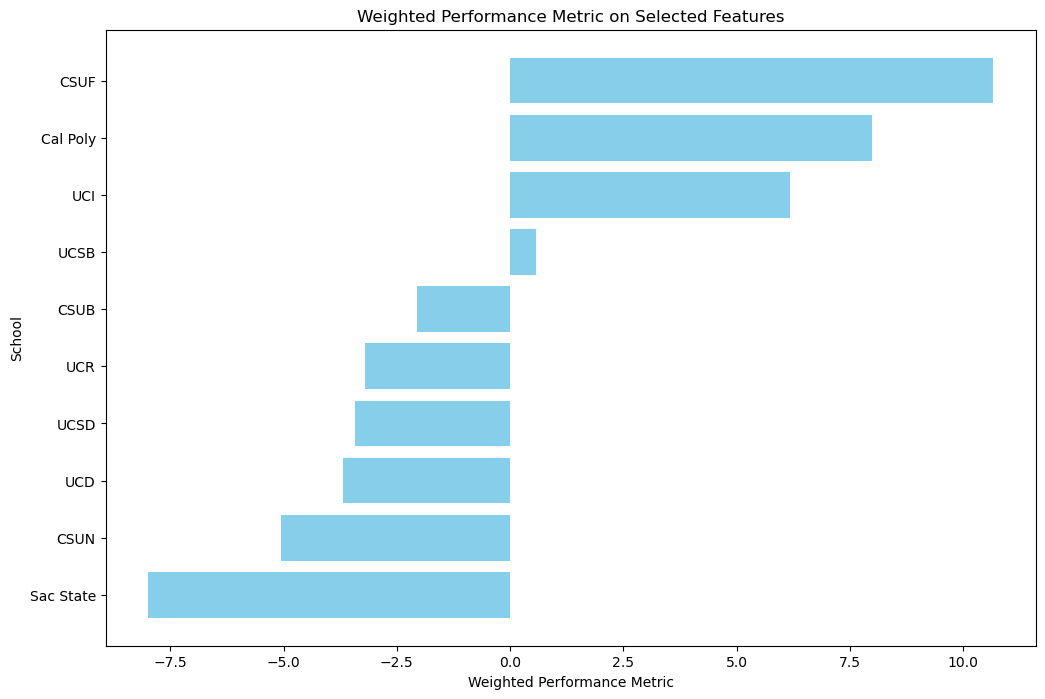

In [28]:
# Features from combined_features
selected_features = [
'Match tempo', 
'Interceptions', 
'Shots on target ratio',
'Low loss ratio', 
'Low Recovery', 
'Total attacks ending with shots ratio', 
'Low recoveries ratio', 
'Clearances', 
'Low cross ratio', 
'Goals',
'Shots on target inside penalty area ratio' 
]

# Weights for top 3 teams and bottom 3 teams. If a team ranked 1st in selected_features, then weights will by multiplied
weight_dict = {
    'CSUF': 2,
    'UCI': 1.5,
    'UCSB': 1,
    'UCSD': -1,
    'CSUN': -1.5,
    'Sac State': -2
}

# Create performance data for each school on selected_features
performance_data = {school: df[selected_features].mean().to_dict() for school, df in dataframes.items()}
performance_df = pd.DataFrame(performance_data).T

# Find the ranks for each feature and initialize weights
ranked_performance_df = performance_df.rank(ascending=False)
weights = pd.Series(0.0, index=performance_df.columns)

# Assign weights based on the top position
for feature in selected_features:
    for school, weight in weight_dict.items():
        if ranked_performance_df.loc[school, feature] == 1:
            weights[feature] = weight

# Normalize the performance data
scaler = StandardScaler()
normalized_performance_df = pd.DataFrame(scaler.fit_transform(performance_df), columns=performance_df.columns, index=performance_df.index)

# Calculate the weighted average
weighted_performance_metric = (normalized_performance_df * weights).sum(axis=1)

# Create df for visualization
weighted_performance_df = pd.DataFrame({
    'School': performance_df.index,
    'Weighted Metric': weighted_performance_metric
})

# Sort the df by the weighted metric
weighted_performance_df = weighted_performance_df.sort_values(by='Weighted Metric', ascending=False)

# Plot the weighted performance metric
plt.figure(figsize=(12, 8))
plt.barh(weighted_performance_df['School'], weighted_performance_df['Weighted Metric'], color='skyblue')
plt.xlabel('Weighted Performance Metric')
plt.ylabel('School')
plt.title('Weighted Performance Metric on Selected Features')
plt.gca().invert_yaxis() 
plt.show()


This scatter plot analysis is crucial because it visualizes how key performance indicators, identified through prior analysis, interact with other correlated features. By focusing on the most strongly correlated feature pairs, we gain insights into which combinations of metrics are most influential across teams. This is particularly important for revealing nuanced patterns that may contribute to success in the NCAA Big West Conference. Understanding these feature interactions can help coaches and teams refine strategies based on how certain metrics complement each other, improving overall performance.

In [30]:
# Here is our final features of interest
features_of_interest = [
    'Match tempo', 
    'Interceptions', 
    'Shots on target ratio',
    'Low loss ratio', 
    'Low Recovery', 
    'Total attacks ending with shots ratio', 
    'Low recoveries ratio', 
    'Clearances', 
    'Low cross ratio', 
    'Goals',
    'Shots on target inside penalty area ratio'
]

# Generate and display scatter plot for the given feature and its best correlated pair
def plot_feature_pair(feature):
    # Exclude non-numeric features
    excluded_features = ['Win', 'xG', 'Team']
    all_features = [f for f in reduced_df.columns if f not in excluded_features]

    # Find the best pair (highest correlated) for the given feature
    best_corr = -1  # Start with a low value to find the highest correlation
    best_pair = None
    
    for potential_pair in all_features:
        if potential_pair != feature:
            corr = reduced_df[feature].corr(reduced_df[potential_pair])
            
            if not pd.isna(corr) and corr > best_corr:
                best_corr = corr
                best_pair = potential_pair
    
    if best_pair is None:
        print(f"No suitable pair found for feature: {feature}")
        return
    
    # Store the average values and teams for legend
    avg_feature_values = []
    avg_pair_values = []
    labels = []

    # Calculate average values
    for team, df in dataframes.items():
        if feature in df.columns and best_pair in df.columns:
            df_numeric = df[[feature, best_pair]].select_dtypes(include='number')
            if df_numeric.shape[1] == 2:
                avg_values = df_numeric.mean()
                avg_feature_values.append(avg_values[feature])
                avg_pair_values.append(avg_values[best_pair])
                labels.append(team)

    # Df for plotting
    scatter_data = pd.DataFrame({
        feature: avg_feature_values,
        best_pair: avg_pair_values,
        'Team': labels
    })

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=scatter_data, x=feature, y=best_pair, hue='Team', palette='tab10', legend='full', s=100)

    # Add average lines
    plt.axhline(y=scatter_data[best_pair].mean(), color='gray', linestyle='--', linewidth=1, label='Mean ' + best_pair)
    plt.axvline(x=scatter_data[feature].mean(), color='gray', linestyle='--', linewidth=1, label='Mean ' + feature)

    plt.title(f'Scatter Plot: {feature} vs {best_pair}')
    plt.xlabel(feature)
    plt.ylabel(best_pair)
    plt.legend(title='Teams', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


The 'Goals' plot illustrates the relationship between 'Goals' and 'Shots on target'. The x-axis shows average goals, while the y-axis represents average shots on target, with each circle representing a team. Teams like CSUF, in the top-right quadrant, excel in both creating and converting scoring opportunities, indicating strong offensive capabilities. In contrast, teams in the bottom-left quadrant, such as Sac State, struggle with both, highlighting areas for improvement. UCI, in the upper-left, creates many chances but needs better finishing, while teams in the bottom-right are highly efficient with fewer shots. This plot offers a clear view of each team's offensive strengths and weaknesses.

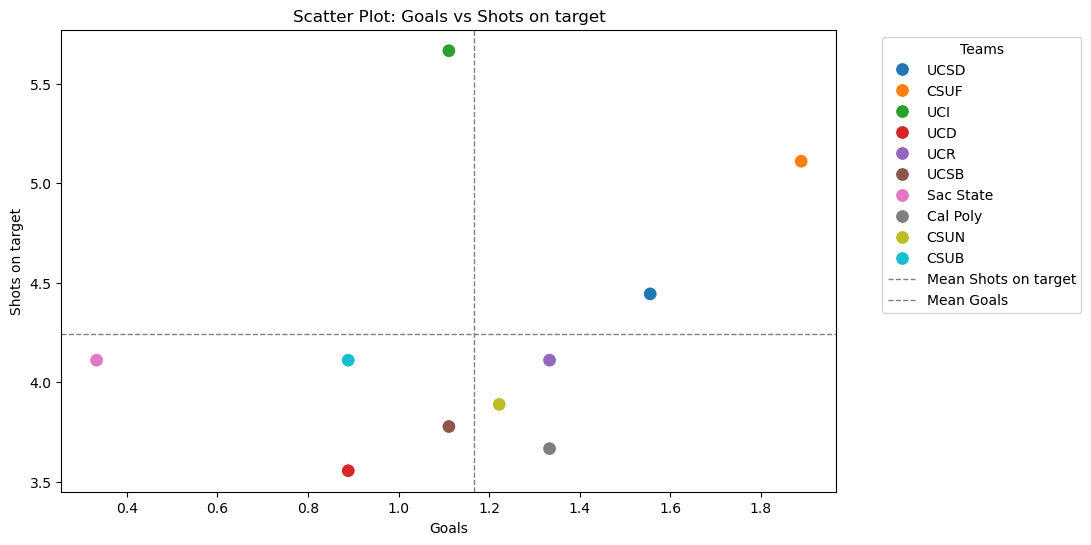

In [32]:
plot_feature_pair('Goals')

The 'Shots on target ratio' plot shows the relationship between the 'Shots on target ratio' and the 'Shots on target inside penalty area ratio'. The x-axis represents the Shots on target ratio, while the y-axis shows the Shots on target inside penalty area ratio. Teams located in the top-right quadrant, like UCR, excel in both aspects, indicating a high efficiency in generating quality shots within the penalty area. Teams in the bottom-left quadrant, such as UCSB, underperform in both metrics, suggesting difficulties in converting opportunities into effective shots. Teams in the top-left quadrant, such as Cal Poly, may focus more on getting quality shots in the penalty area but are less efficient in ensuring those shots are on target. Meanwhile, teams like UCI in the bottom-right quadrant are effective at getting shots on target but may struggle to position those shots within the penalty area. This plot provides insights into each team's shooting efficiency and positioning.

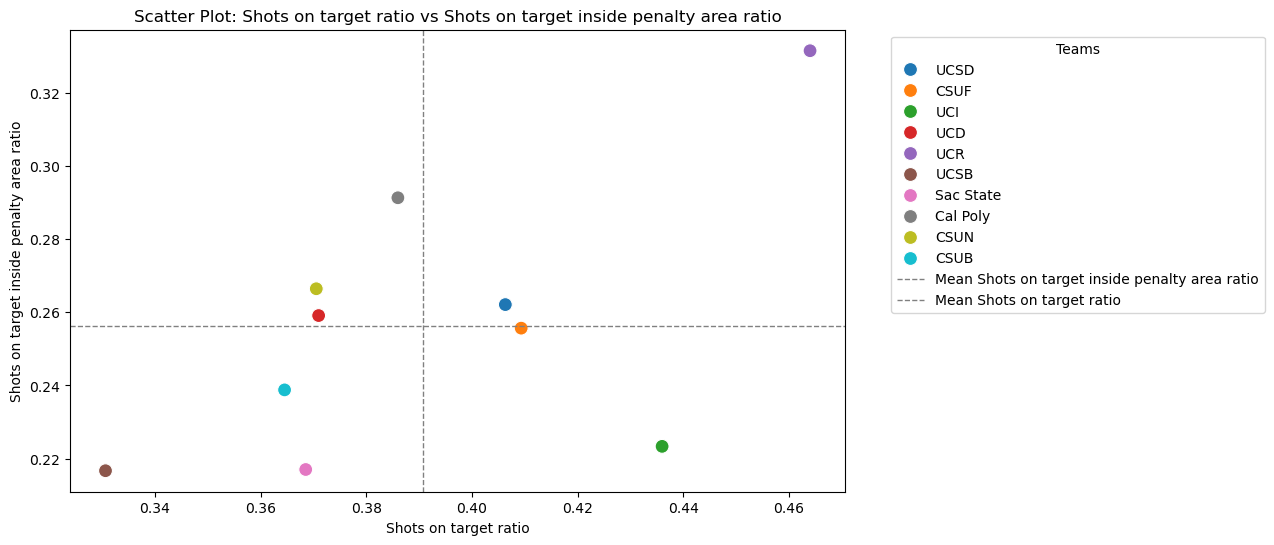

In [34]:
# This is both for the plot for Shots on target ratio and Shots on target inside penalty area ratio as they are each others highly correlated feature
plot_feature_pair('Shots on target ratio')

The 'Total attacks ending with shots ratio' plot illustrates the relationship between the 'Total attacks ending with shots ratio' and 'Total attacks ending with shots'. The x-axis represents the total attacks ending with shots ratio, while the y-axis shows the total number of attacks ending with shots. Teams in the top-right quadrant, like CSUF, excel in both the ratio and the total number of successful attacks, indicating high efficiency in converting attacks into shots. Teams in the bottom-left quadrant, such as CSUB, are less effective in converting their attacks into shots, suggesting possible difficulties in their offensive strategy. Teams like CSUN, located in the bottom-right quadrant, maintain a higher ratio but have fewer overall attacks ending in shots, indicating a focus on quality over quantity. Meanwhile, teams in the top-left quadrant, such as Sac State, manage a higher number of attacks but might struggle with conversion efficiency. This plot provides insight into each team's attacking efficiency and overall effectiveness in generating shots from their attacks.

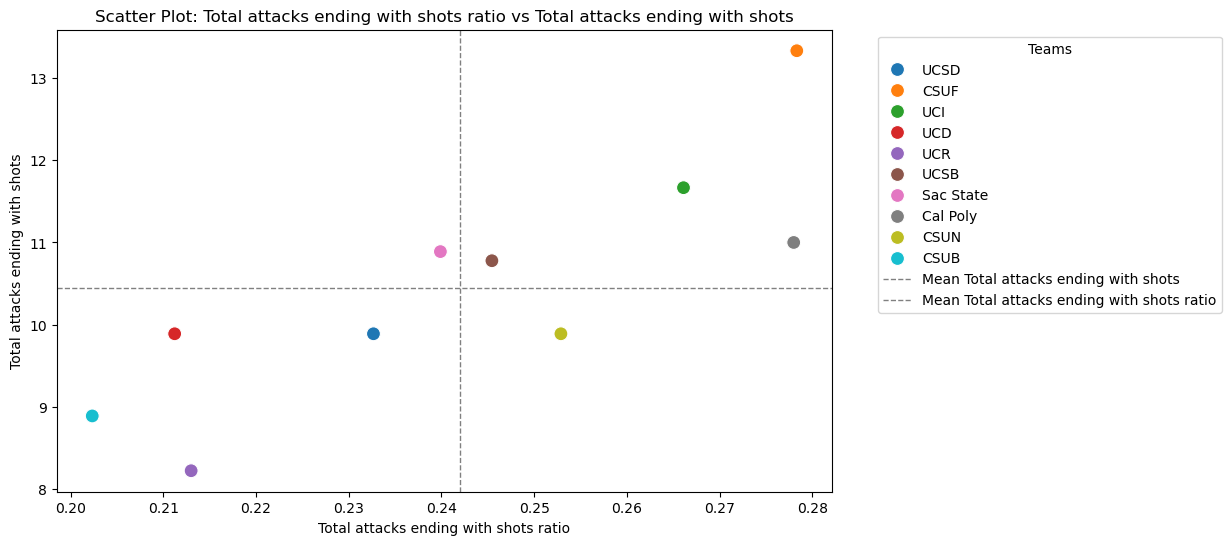

In [36]:
plot_feature_pair('Total attacks ending with shots ratio')

The 'Match tempo' plot shows the relationship between 'Match tempo' (the number of team passes per minute of pure ball possession) and 'Total accurate passes'. The x-axis represents the match tempo, while the y-axis shows the total accurate passes. Teams in the top-right quadrant, such as UCSB and UCI, demonstrate both a high match tempo and a high number of accurate passes, indicating a fast-paced and precise passing play-style. Conversely, teams like CSUN and UCSD in the bottom-left quadrant exhibit a slower tempo with fewer accurate passes, suggesting a more deliberate but less effective passing strategy. The position of these teams highlights their different tactical approaches to ball possession and passing efficiency. Understanding this relationship is crucial for analyzing a team's ability to maintain possession and control the game, with higher tempo and accurate passing often contributing to more dynamic and successful offensive strategies.

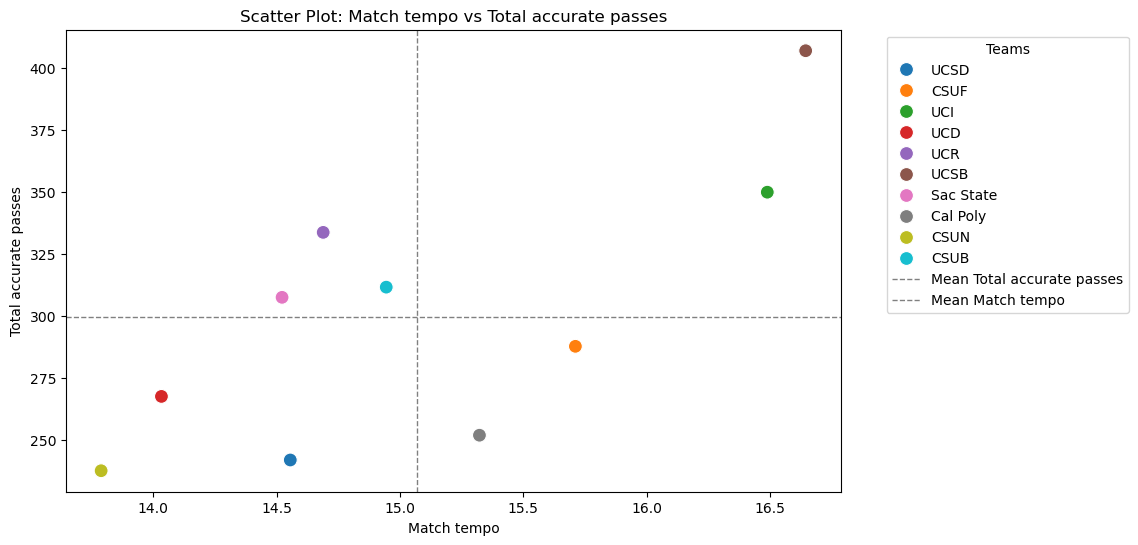

In [38]:
plot_feature_pair('Match tempo')

The 'Accurate passes to penalty area' plot illustrates the relationship between 'Accurate passes to the penalty area' and 'Total passes to the penalty area'. The x-axis represents the number of accurate passes to the penalty area, while the y-axis shows the total number of passes to the penalty area. Teams in the top-right quadrant, such as UCSB and UCI, excel in both the volume of passes and their accuracy, indicating effective ball delivery into dangerous areas. Teams in the bottom-left quadrant, such as CSUB and CSUN, perform below average in both metrics, suggesting a need for improvement in both pass accuracy and volume. Teams like CSUF, in the bottom-right quadrant, have a high pass accuracy but may attempt fewer passes overall, focusing on precision. Meanwhile, teams closer to the top-left quadrant, like Sac State, deliver many passes to the penalty area but struggle with accuracy. This plot provides insights into each team’s ability to effectively and accurately deliver the ball into critical attacking zones, which is crucial for creating goal-scoring opportunities. Teams with high accuracy and volume are more likely to maintain offensive pressure and break down defenses, while teams with low accuracy may waste potential opportunities, highlighting areas where they need to focus on improving their strategy and execution to be more competitive. Understanding these dynamics can help teams adjust their tactics to optimize their attacking potential and overall performance on the field.

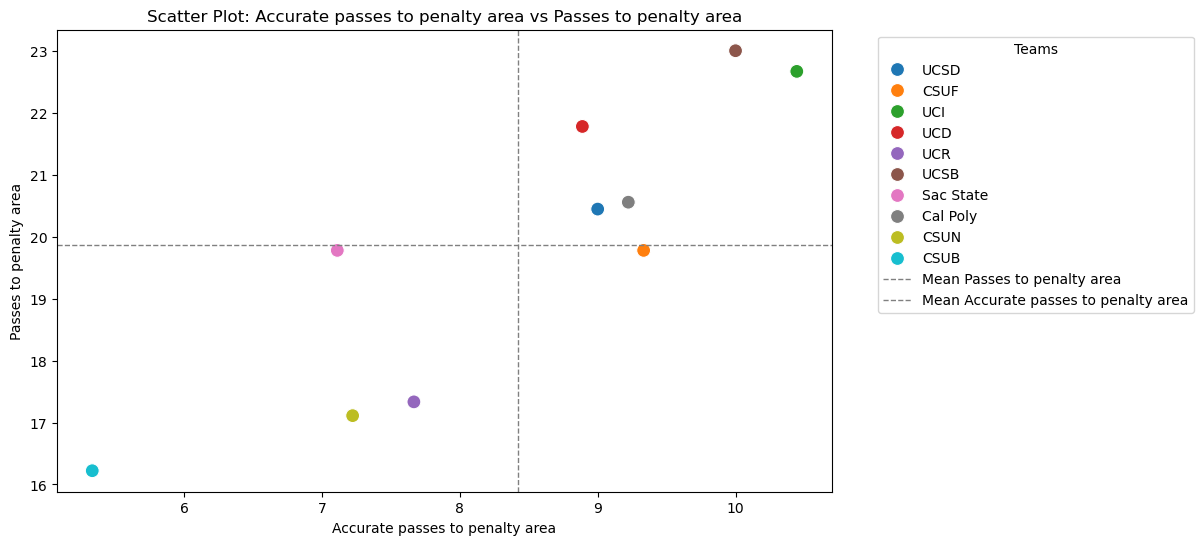

In [40]:
plot_feature_pair('Accurate passes to penalty area')

The 'Low cross ratio' plot shows the relationship between the 'Low cross ratio' and the number of 'Low crosses'. The x-axis represents the low cross ratio, while the y-axis indicates the total number of low crosses. Teams in the top-right quadrant, such as CSUF, excel in both the frequency and ratio of low crosses, suggesting a strong focus on delivering low, driven crosses that may be harder for defenders to intercept and goalkeepers to collect. Teams in the bottom-left quadrant, such as UCSD, have both a low number of low crosses and a low cross ratio, which could indicate a different offensive strategy that relies less on low crosses. Teams like UCI, in the bottom-right quadrant, maintain a higher ratio of low crosses but may attempt fewer overall, suggesting a strategic use of low crosses in specific situations. Conversely, teams in the top-left quadrant, like UCSB, produce a higher volume of low crosses but may not achieve as high a ratio, potentially indicating mixed success with this approach. Understanding these patterns is important because low crosses can be an effective offensive strategy to create scoring opportunities, especially against teams that are strong in aerial defense. By analyzing the use and effectiveness of low crosses, teams can better tailor their offensive strategies to exploit weaknesses in their opponents' defenses.

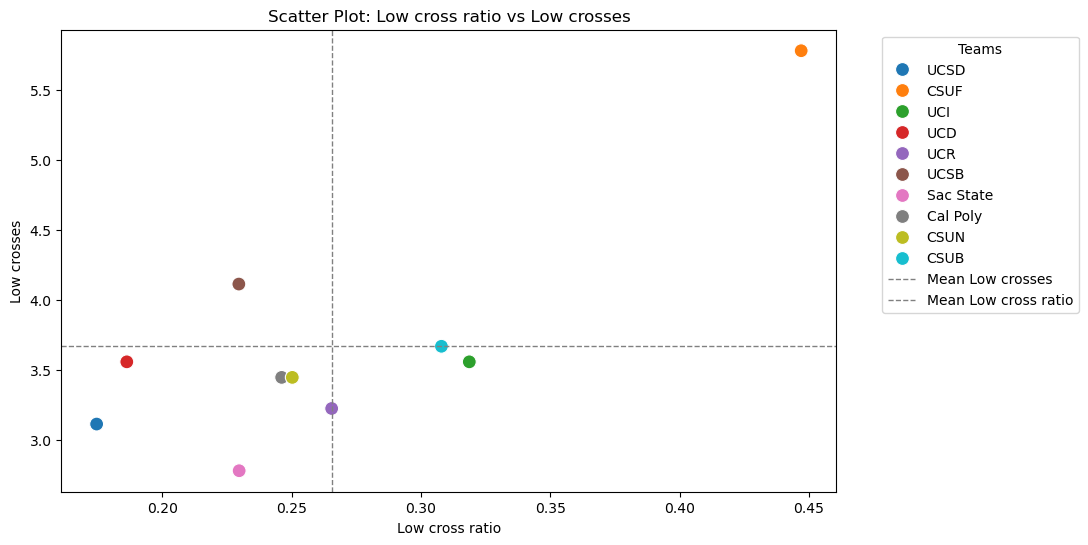

In [42]:
plot_feature_pair('Low cross ratio')

The 'Clearances' plot shows the relationship between 'Clearances' and the 'Low loss ratio'. The x-axis represents the number of clearances, while the y-axis indicates the low loss ratio. Teams in the top-right quadrant, such as CSUN, demonstrate a strong defensive performance by effectively clearing the ball while maintaining a low rate of losing possession in critical areas, indicating solid defensive organization and decision-making under pressure. Teams in the bottom-left quadrant, such as UCSD, have fewer clearances and a higher rate of losing possession, suggesting potential vulnerabilities in their defensive play and challenges in maintaining possession when under pressure. Teams in the bottom-right quadrant, like Cal Poly, make a higher number of clearances but may be more prone to losing possession in these situations, indicating a reactive rather than a controlled defensive approach. Meanwhile, teams like CSUF, positioned in the top-left quadrant, minimize possession loss but do not rely heavily on clearances, which could reflect a more possession-oriented defensive strategy. Understanding these dynamics is crucial because it highlights the effectiveness and style of each team's defensive strategy. High clearance numbers coupled with low dispossession rates suggest a balanced approach, whereas discrepancies between these metrics can reveal areas where teams might need to adjust their tactics to prevent defensive breakdowns and maintain better control of the game.

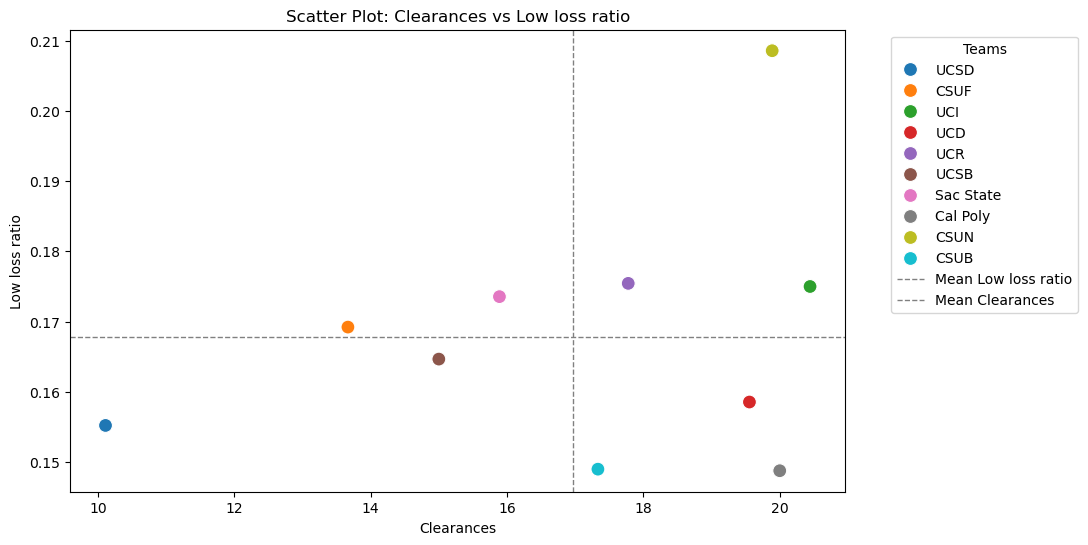

In [44]:
plot_feature_pair('Clearances')

The 'Interceptions' plot illustrates the relationship between the number of 'Interceptions' and 'Clearances', with the x-axis representing interceptions and the y-axis showing clearances. Teams in the top-right quadrant, like UCD, excel in both metrics, indicating strong defensive capabilities. Teams in the bottom-left quadrant, such as CSUF, are below average in both, suggesting either potential weaknesses in their defensive efforts or reflects a more possession-oriented defensive strategy. Teams like CSUN, in the top-left quadrant, focus more on clearances but may need to improve in interceptions, whereas UCSD in the bottom-right excels in interceptions but might require more focus on clearances. This plot is crucial because it highlights each team's defensive balance and areas where strategic adjustments might be necessary. Teams strong in both metrics demonstrate a well-rounded defense essential for preventing goals and maintaining stability, while those excelling in only one area may have a defensive imbalance that could be exploited by opponents. By identifying these strengths and weaknesses, coaches can refine defensive tactics to create a more cohesive and resilient defensive unit, ultimately reducing the risk of conceding goals.

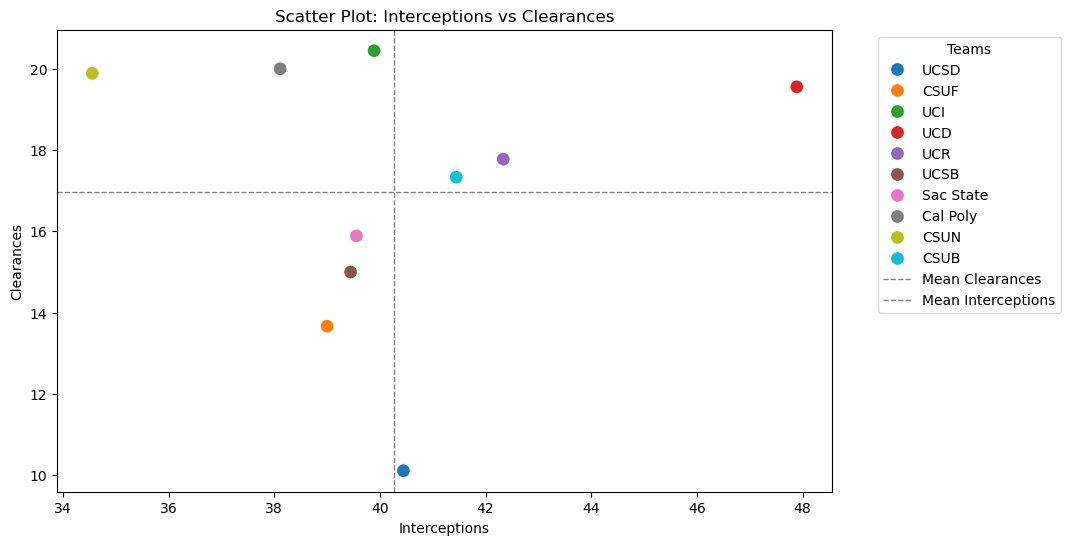

In [46]:
plot_feature_pair('Interceptions')

The 'Low loss ratio' plot illustrates the relationship between the 'Low loss ratio' and the 'Low recoveries ratio'. The x-axis represents the low loss ratio, indicating how often teams lose possession in their defensive third, while the y-axis shows the Low recoveries ratio, reflecting how frequently they recover possession in their defensive third. Teams in the top-right quadrant, such as CSUN, tend to lose the ball more often in their defensive third while also recovering it in the same area, suggesting a high reliance on defensive efforts close to their goal. Teams like UCSB, located in the top-left quadrant, focus on recovering possession in their defensive third but lose the ball less frequently there, possibly due to stronger ball retention higher up the field. Meanwhile, teams in the bottom-left quadrant, like Cal Poly, lose possession less frequently in their defensive third and also recover it less often there, indicating a more balanced or higher-field play. Teams like Sac State, located in the bottom-right quadrant, exhibit a higher Low loss ratio, meaning they lose possession more frequently in their defensive third, but recover the ball less often in that same area, suggesting a potential vulnerability where they lose the ball in dangerous positions and struggle to win it back in those areas. This plot offers insights into teams' tendencies to either defend deeper or maintain possession higher up the field.

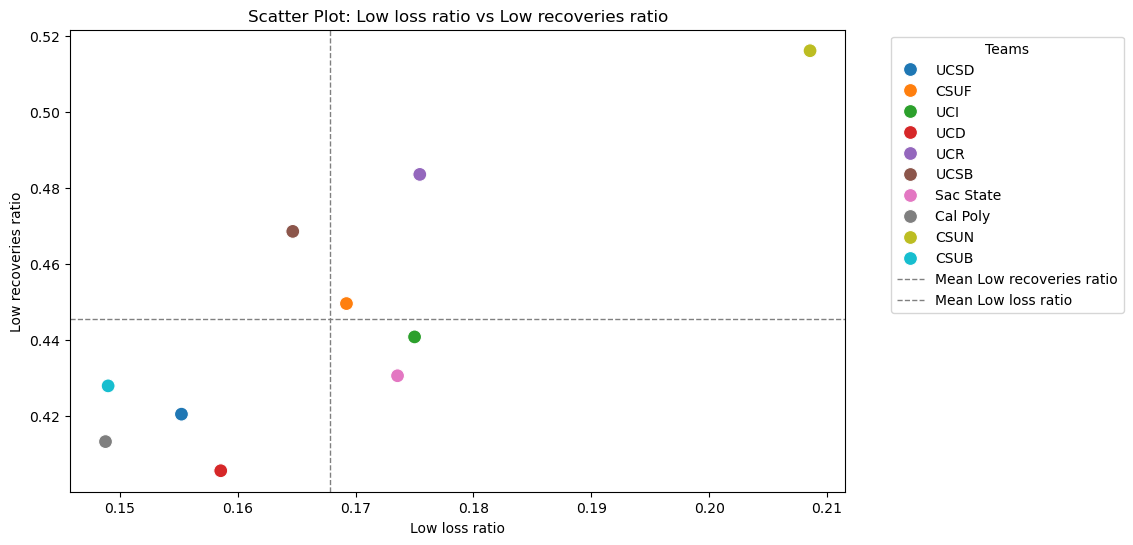

In [48]:
plot_feature_pair('Low loss ratio')

The 'Low recoveries ratio' plot illustrates the relationship between 'Low recoveries ratio' and 'Low recovery'. The x-axis represents low recoveries ratio, while the y-axis indicates low recovery. Teams in the top-right quadrant, like UCSB and CSUN, excel in both metrics, suggesting a strong ability to recover possession and minimize losses during recoveries. Teams in the bottom-left quadrant, such as UCSD and Sac State, show weaker performance in both areas, indicating potential deficiencies in their ability to effectively regain possession and retain it. Teams in the top-left quadrant, like UCI, focus more on minimizing low recoveries but may need to improve their effectiveness in turning recoveries into possession. This plot is significant because it highlights each team's ability to recover and retain possession, which are critical components of a resilient defensive strategy. Teams that perform well in both metrics are likely to maintain better control of the game, reducing the opponent's opportunities to capitalize on turnovers, while teams with disparities between these metrics may need to refine their defensive tactics to achieve a more balanced and effective recovery system.

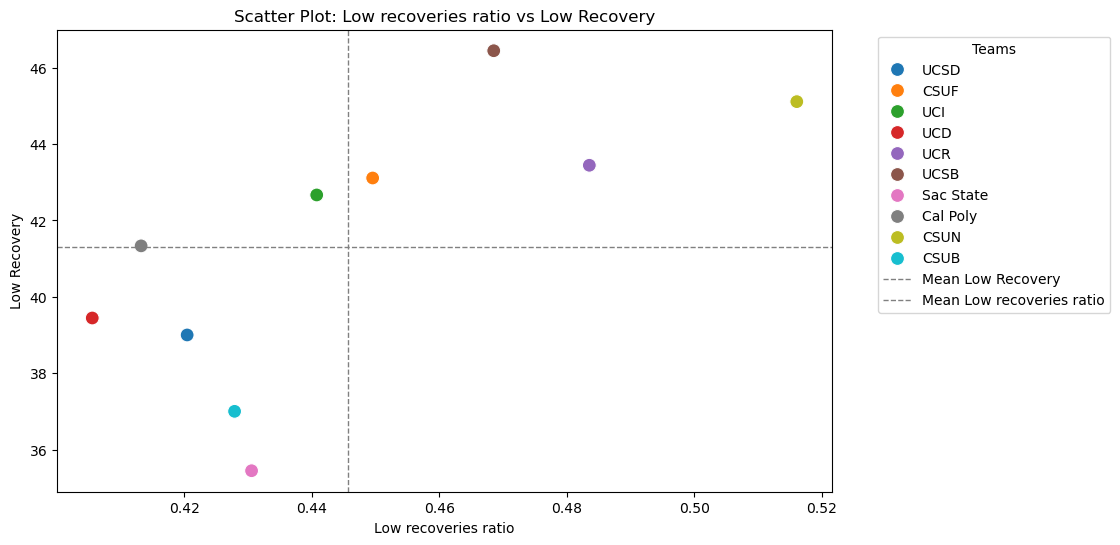

In [50]:
# This is both for the plot for Low Recoveries ratio and Low Recovert as they are each others highly correlated feature
plot_feature_pair('Low recoveries ratio')

<a id='results_summary'></a>
# Results Summary
    This analysis has revealed that a combination of offensive, defensive, and transitional metrics plays a pivotal role in determining success in the NCAA Division 1 Men's Big West Conference. This means that winning isn’t just about excelling in one aspect of play, such as scoring goals, but requires a holistic approach that integrates multiple facets of the game. Teams must be proficient in offensive creation, defensive resilience, and managing transitions between these phases to maintain control over the match. A well-rounded team that balances attacking aggression with defensive stability and effective ball recovery will have the upper hand, particularly in a league where small margins can make a significant difference. In fact, this season, just one game or a mere three points has separated 7th place from 3rd place, highlighting the razor-thin margins between teams. By mastering these key areas, teams can consistently put themselves in advantageous positions, both tactically and in terms of game outcomes.
    
    First, 'Shots on target inside penalty area ratio' highlight the importance of generating high-quality chances close to the opponent's goal. These metrics underline that teams with a higher concentration of accurate shots from dangerous areas inside the penalty box tend to outperform their peers, as these opportunities have a higher probability of resulting in goals. This implies that not just the volume of shots, but the precision and positioning of these shots, especially in high-pressure areas, are key to scoring.

    Next, 'Match tempo' indicates that maintaining a high tempo correlates with successful offensive plays, keeping the opposition on the back foot. Teams that successfully execute a fast-paced, high-tempo strategy often force their opponents into defensive errors, disrupt their rhythm, and create more attacking opportunities.

    On the defensive side, metrics like 'Interceptions', 'Low loss ratio', and 'Low recoveries ratio' underscore the importance of regaining and maintaining possession in crucial areas of the pitch. Minimizing 'Low loss ratio' is essential, as giving the ball away in defensive areas can lead to dangerous counter-attacking opportunities for the opponent. Similarly, 'Low recoveries ratio' highlights that teams who recover the ball primarily in their defensive third may face pressure, but a team’s ability to win back possession in these moments is critical to preventing opposition chances. The relationship between these two metrics suggests that successful teams manage transitions carefully, minimizing ball losses near their goal while being adept at recovering the ball defensively.

    'Clearances' serve as another vital defensive indicator, illustrating how quickly and effectively teams can alleviate pressure in dangerous situations. High clearance counts often signify the ability to maintain defensive stability, keeping opponents from capitalizing on sustained pressure or chaos in the penalty box.

    On the attacking front, 'Total attacks ending with shots ratio' is a crucial offensive measure of efficiency. Teams that consistently turn their build-up play into shots on target are much more likely to capitalize on opportunities. Likewise, 'Shots on target ratio' reflects the precision of a team’s shooting, emphasizing that converting a high percentage of shots into shots on target puts significant pressure on the opposition’s defense and goalkeeper.

    Finally, 'Goals' serve as the ultimate determinant of match outcomes, but this study shows that teams achieving higher values in the above metrics are more likely to create the conditions necessary to score. While many factors can influence the result of a game, excelling across these performance indicators gives a team the best chance to dominate, control the flow of the game, and ultimately secure victories in the competitive landscape of Big West Conference soccer.

    In summary, success in this conference hinges on a balance between attacking efficiency, defensive resilience, and the ability to control transitions between attack and defense. Teams that can maintain high tempo, execute precise attacking plays, recover the ball quickly in critical areas, and limit defensive errors will significantly improve their chances of winning. These metrics provide a roadmap for teams seeking to optimize their strategies and performance, both on the training pitch and during matches.